### KMeans

In [1]:
import keras
from keras.datasets import fashion_mnist 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans 

import pandas as pd

2022-05-01 19:34:28.136814: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-01 19:34:28.136918: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from skimage import io, img_as_ubyte
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold


In [17]:
# Set the paths for image files, labels etc
faces_path = "../data/Faces/"
labels_path = "../data/labels.csv"
names_path = "../data/filenames.txt"

In [18]:
# Read labels as pandas object from labels.csv
labels_columns = ['age', 'gender', 'race']
labels = pd.read_csv(labels_path)
labels = pd.DataFrame(data=labels.values, columns=labels_columns)

In [19]:
def combine_labels(row):
#     print(row.gender, row.race, row.age_num)
    return str(row.gender) + str(row.race) + str(row.age_num)

In [20]:
bins= [0,2,4,13,20,60,120]
age_groups = ['Infant','Toddler','Kid','Teen','Adult','Old']
age_labels = ['0', '1', '2', '3', '4', '5']
labels['age_num'] = pd.cut(labels['age'], bins=bins, labels=age_labels, right=False)
labels['age_group'] = pd.cut(labels['age'], bins=bins, labels=age_groups, right=False)

labels['combined'] = labels.apply(lambda row: combine_labels(row), axis=1)
labels

,age,gender,race,age_num,age_group,combined
0,100,0,0,5,Old,005
1,100,1,0,5,Old,105
2,100,1,0,5,Old,105
3,100,1,0,5,Old,105
4,100,1,0,5,Old,105
...,...,...,...,...,...,...
23699,9,1,3,2,Kid,132
23700,9,1,3,2,Kid,132
23701,9,1,4,2,Kid,142
23702,9,1,4,2,Kid,142


In [22]:
# Open a random image to get dimensions
test_img_name = 0
test_img = io.imread(faces_path+f"{test_img_name}.jpg", as_gray=True)
h, w = test_img.shape
del test_img

In [23]:
def load_images(labels, h, w):
    X= np.empty((len(labels), h*w))

    for i, index in enumerate(labels.index):
        a = io.imread(faces_path+f"{index}.jpg", as_gray=True)
        a = img_as_ubyte(a)
        X[i, :] = a.reshape(1, -1)

    del a
    print('Done loading images')
    
    return X

In [24]:
# subset for testing
labels = labels[:2000]

In [10]:
X = load_images(labels, h, w)

Done loading images


In [25]:
y = labels["combined"].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True)

In [26]:
#Sanity check
print ("The shape of X is " + str(X_train.shape))
print ("The shape of y is " + str(y_train.shape)) #We will be using y only to check our clustering 

The shape of X is (1340, 40000)
The shape of y is (1340,)


In [27]:
unique, counts = np.unique(y_train, return_counts=True)
unique, counts

(array(['000', '002', '003', '005', '010', '012', '013', '020', '022',
        '023', '025', '032', '033', '042', '043', '102', '103', '105',
        '112', '113', '115', '122', '123', '125', '132', '133', '135',
        '142', '143'], dtype=object),
 array([ 90,  72, 238,   4,  12,   9,  47, 181,   6,  20,   1,   8,  31,
         11,  27,  82, 256,  12,  11,  57,   2,  13,  29,   4,  11,  44,
          2,  10,  50]))

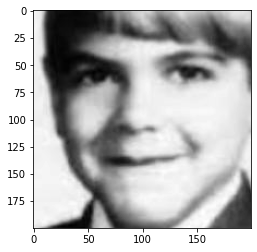

male


In [28]:
#Visualise a face
n = 0 #Enter Index here to View the image 
plt.imshow(X_train[n, :].reshape(h,w), cmap = 'gray')
plt.show()

gender = 'female' if y_train[n]==1 else 'male'
print(gender)

# PCA (Principle Component Analysis)

In [29]:
# To perform PCA we must first change the mean to 0 and variance to 1 for X using StandardScalar
dataSet = StandardScaler().fit_transform(X_train) #(mean = 0 and variance = 1)

In [30]:
from sklearn.decomposition import PCA
# Make an instance of the Model
variance = 0.98 #The higher the explained variance the more accurate the model will remain
pca = PCA(variance)

In [31]:
#fit the data according to our PCA instance
pca.fit(dataSet)

PCA(n_components=0.98)

In [32]:
print("Number of components before PCA  = " + str(X.shape[1]))
print("Number of components after PCA 0.98 = " + str(pca.n_components_)) #dimension reduced from 40000

Number of components before PCA  = 40000
Number of components after PCA 0.98 = 351


In [33]:
#Transform our data according to our PCA instance
dataSet = pca.transform(dataSet)

In [34]:
print("Dimension of our data after PCA  = " + str(dataSet.shape)) 

Dimension of our data after PCA  = (1340, 351)


In [35]:
#To visualise the data inversed from PCA
approximation = pca.inverse_transform(dataSet)
print("Dimension of our data after inverse transforming the PCA  = " + str(approximation.shape))

Dimension of our data after inverse transforming the PCA  = (1340, 40000)


male


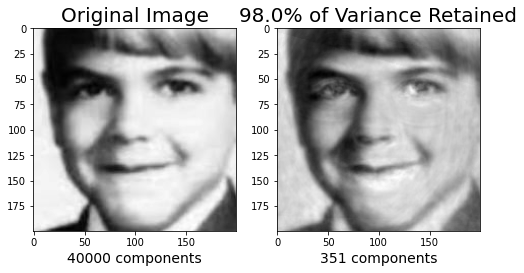

In [36]:
#image reconstruction using the less dimensioned data
plt.figure(figsize=(8,4));

n = 0 #index value, change to view different data

# Original Image
plt.subplot(1, 2, 1);
plt.imshow(X_train[n].reshape(h,w),cmap = 'gray');
plt.xlabel(str(X_train.shape[1])+' components', fontsize = 14)
plt.title('Original Image', fontsize = 20);

# 351 principal components
plt.subplot(1, 2, 2);
plt.imshow(approximation[n].reshape(h,w),cmap = 'gray');
plt.xlabel(str(dataSet.shape[1]) +' components', fontsize = 14)
plt.title(str(variance * 100) + '% of Variance Retained', fontsize = 20);

gender = 'female' if y_train[n]==1 else 'male'
print(gender)

### K-MEANS

In [37]:
# THIS CODE TAKES A LONG TIME TO RUN, IT IS TO FIND THE n_init VALUE.
#We will use k = 2, not the best choice but for simplicity as the GENDER has 2 values
# inertia = []
# for k in range(5, 100):
#     kmeans = KMeans(init = "k-means++",n_clusters=10, n_init = k,random_state=1).fit(dataSet)
#     inertia.append(np.sqrt(kmeans.inertia_))

# plt.plot(range(5, 100), inertia, marker='s');
# plt.xlabel('$k$')
# plt.ylabel('$J(C_k)$');

In [38]:
#n_clusters = 2 because GENDER has 2 values. Not the best value but a simple logic.
k_means = KMeans(init = "k-means++", n_clusters = 29, n_init = 20)

In [39]:
#fit the data to our k_means model
k_means.fit(dataSet)

KMeans(n_clusters=29, n_init=20)

In [40]:
k_means_labels = k_means.labels_ #List of labels of each dataset
print("The list of labels of the clusters are " + str(np.unique(k_means_labels)))

The list of labels of the clusters are [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28]


In [41]:
G = len(np.unique(k_means_labels)) #Number of labels

#2D matrix  for an array of indexes of the given label
cluster_index= [[] for i in range(G)]
for i, label in enumerate(k_means_labels,0):
    for n in range(G):
        if label == n:
            cluster_index[n].append(i)
        else:
            continue   

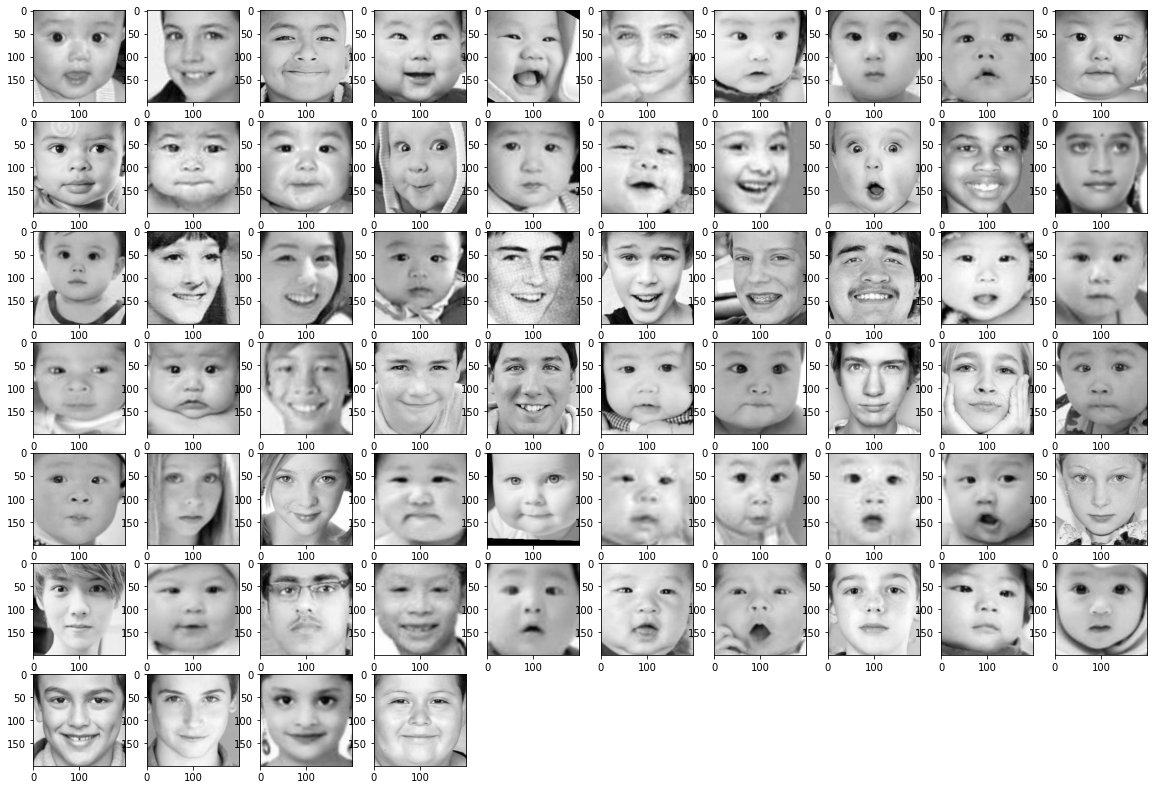

In [50]:
#Visualisation for clusters = clust
plt.figure(figsize=(20,20));
clust = 1 # enter label number to visualise

cluster_len = len(cluster_index[clust])
num = cluster_len if cluster_len<100 else 100 # num of data to visualize from the cluster
for i in range(1,num): 
    plt.subplot(10, 10, i); #(Number of rows, Number of column per row, item number)
    plt.imshow(X_train[cluster_index[clust][i]].reshape(h,w), cmap = 'gray');
    
plt.show()

In [73]:
y_train_df = pd.DataFrame(y_train)
cols = y_train_df[0].str.split(pat='',expand=True)
y_train_df['gender'] = cols[1]
y_train_df['race'] = cols[2]
y_train_df['age_group'] = cols[3]

y_train_gender = y_train_df['gender'].to_numpy()
y_train_race = y_train_df['race'].to_numpy()
y_train_age = y_train_df['age_group'].to_numpy()


In [84]:
Y_clust_gender = [[] for i in range(G)]
for n in range(G):
    Y_clust_gender[n] = y_train_gender[cluster_index[n]] #Y_clust[0] contains array of "correct" category from y_train for the cluster_index[0]
    assert(len(Y_clust_gender[n]) == len(cluster_index[n])) #dimension confirmation

In [77]:
Y_clust_race = [[] for i in range(G)]
for n in range(G):
    Y_clust_race[n] = y_train_race[cluster_index[n]] #Y_clust[0] contains array of "correct" category from y_train for the cluster_index[0]
    assert(len(Y_clust_race[n]) == len(cluster_index[n])) #dimension confirmation

In [78]:
Y_clust_age = [[] for i in range(G)]
for n in range(G):
    Y_clust_age[n] = y_train_age[cluster_index[n]] #Y_clust[0] contains array of "correct" category from y_train for the cluster_index[0]
    assert(len(Y_clust_age[n]) == len(cluster_index[n])) #dimension confirmation

In [85]:
#counts the number of each category in each cluster
def counter(cluster):
    unique, counts = np.unique(cluster, return_counts=True)
    label_index = dict(zip(unique, counts))
    return label_index

In [202]:
#A function to plot a bar graph for visualising the number of items of certain category in a cluster
def plotter(label_dict, class_names):
    plt.bar(range(len(label_dict)), list(label_dict.values()), align='center')
    a = []
    for i in [*label_dict]: a.append(class_names[int(i)])
    plt.xticks(range(len(label_dict)), list(a), rotation=45, rotation_mode='anchor')

In [162]:
def fix_missing_dictionary(dictionary, class_names):
    for class_name in class_names.keys():
        if str(class_name) not in dictionary:
            dictionary[str(class_name)] = 0
            
    
    key_order = [str(key) for key in class_names.keys()]
    Ordered_Dict = {k : dictionary[k] for k in key_order}

    return Ordered_Dict

In [216]:
#race
label_count_race= [[] for i in range(G)]
for n in range(G):
    label_count_race[n] = counter(Y_clust_race[n])

class_names_race = {0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Other'}

for n in range(G):
    label_count_race[n] = fix_missing_dictionary(label_count_race[n], class_names_race)
    

# label_count[0]
#Bar graph with the number of items of different categories clustered in it
# plt.figure(figsize=(20,100))
# for i in range (1,30):
#     plt.subplot(15, 2, i)
#     plotter(label_count[i-1], class_names) 
#     plt.title("Cluster" + str(i-1))

In [217]:
#age
label_count_age= [[] for i in range(G)]
for n in range(G):
    label_count_age[n] = counter(Y_clust_age[n])

# label_count[1] #Number of items of a certain category in cluster 1
class_names_age = {0: 'Infant', 1: 'Toddler', 2: 'Kid', 3: 'Teen', 4: 'Adult', 5: 'Old'}

for n in range(G):
    label_count_age[n] = fix_missing_dictionary(label_count_age[n], class_names_age)
    
#Bar graph with the number of items of different categories clustered in it
# plt.figure(figsize=(20,70))
# for i in range (1,30):
#     plt.subplot(15, 2, i)
#     plotter(label_count[i-1], class_names) 
#     plt.title("Cluster" + str(i-1))

In [218]:
# gender
label_count_gender= [[] for i in range(G)]
for n in range(G):
    label_count_gender[n] = counter(Y_clust_gender[n])

class_names_gender = {0: 'Male', 1: 'Female'}
for n in range(G):
    label_count_gender[n] = fix_missing_dictionary(label_count_gender[n], class_names_gender)
    
    
#Bar graph with the number of items of different categories clustered in it
# plt.figure(figsize=(20,60))
# for i in range (1,30):
#     plt.subplot(15, 2, i)
#     plotter(label_count[i-1], class_names) 
#     plt.title("Cluster" + str(i-1))

/tmp/ipykernel_31375/4125423587.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(20,5))


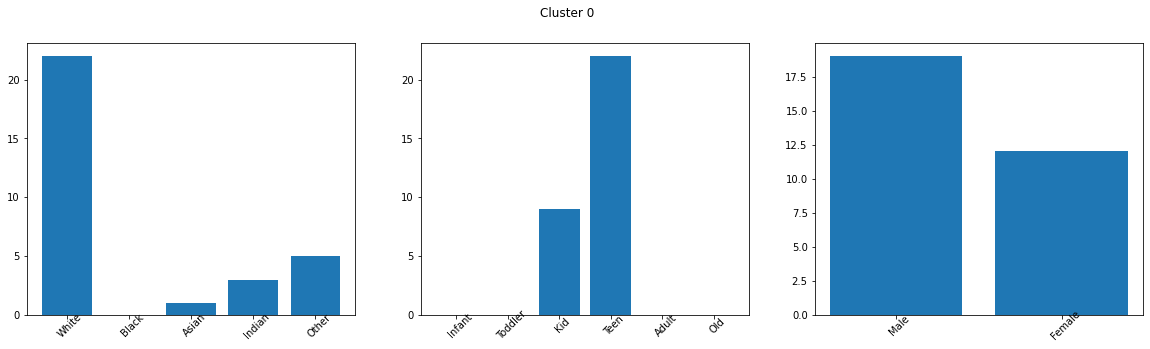

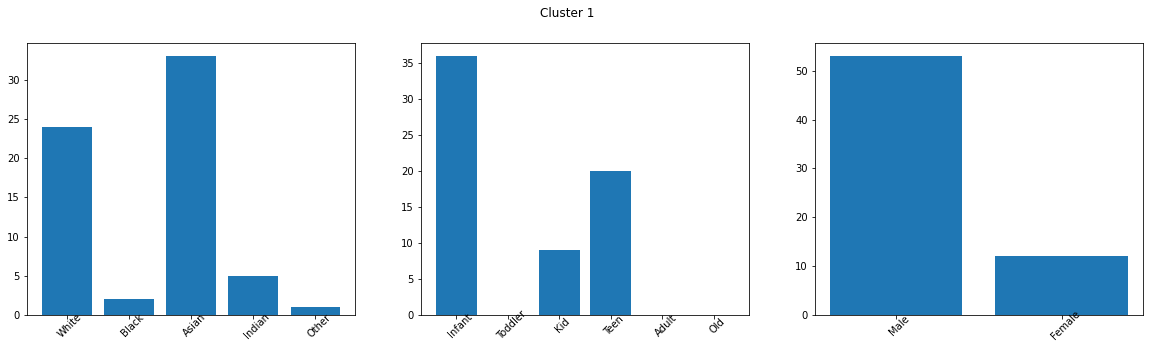

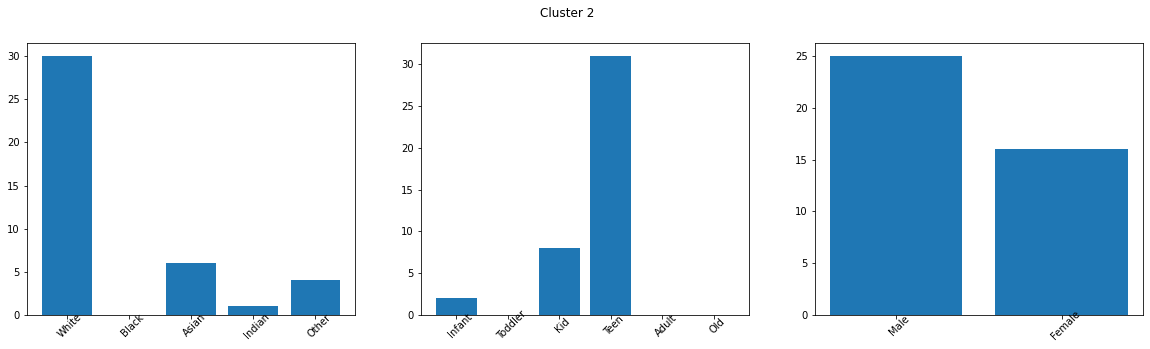

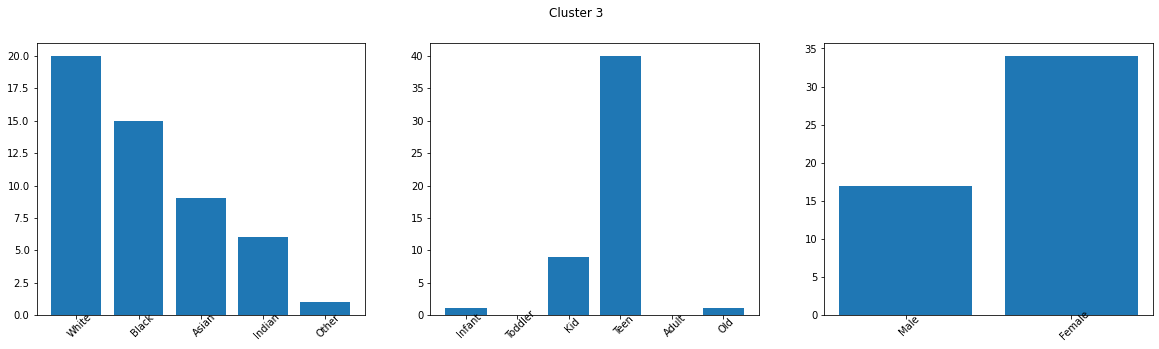

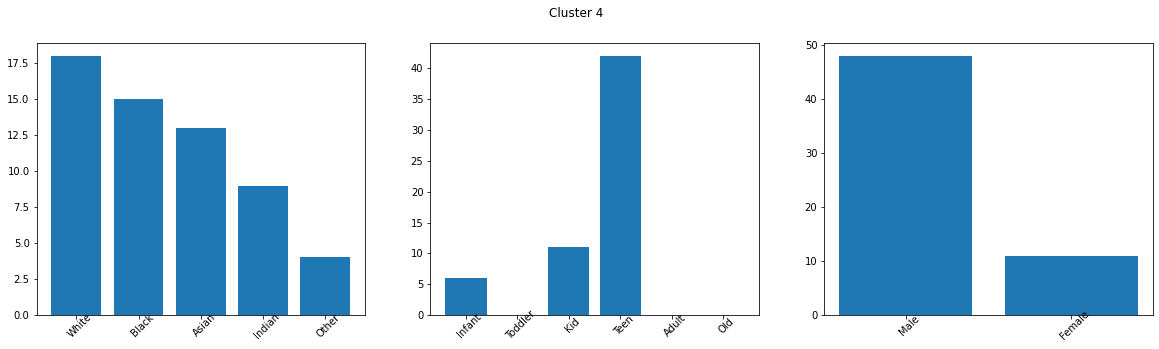

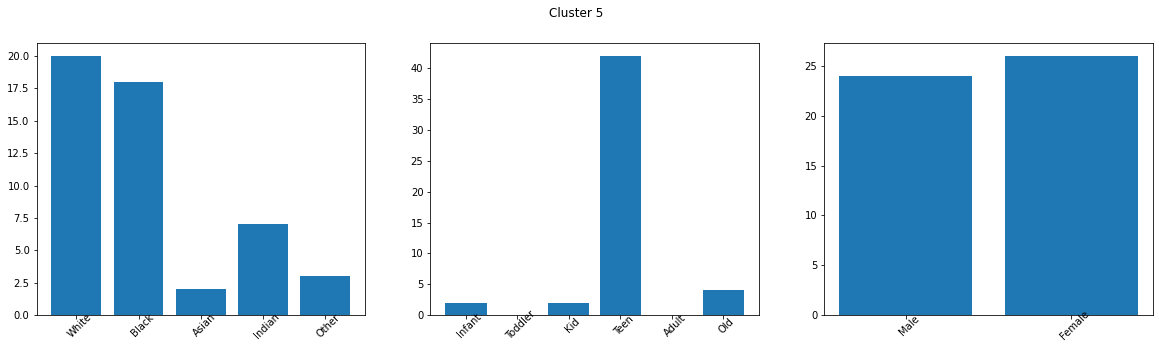

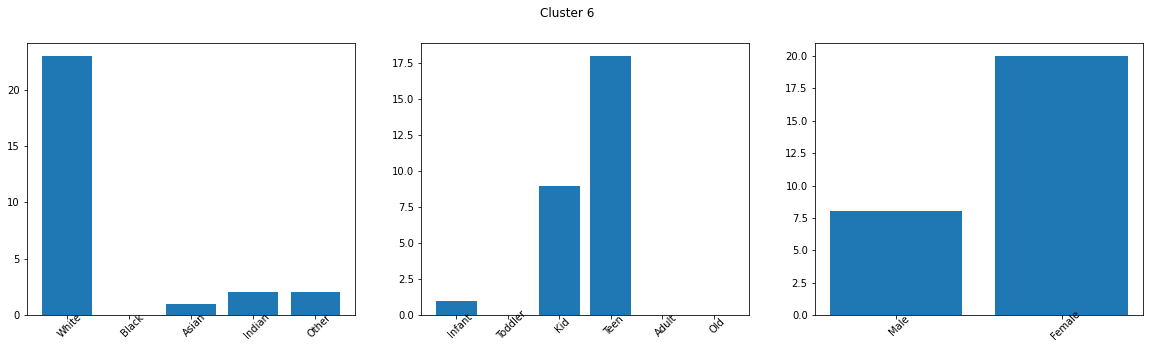

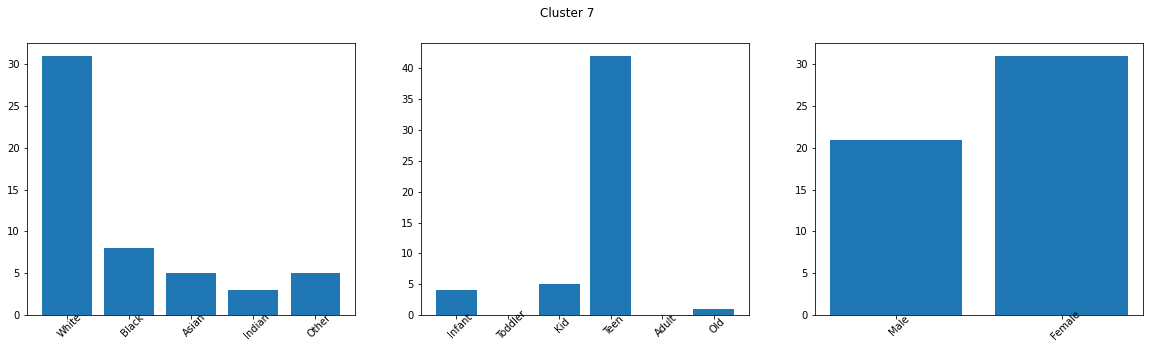

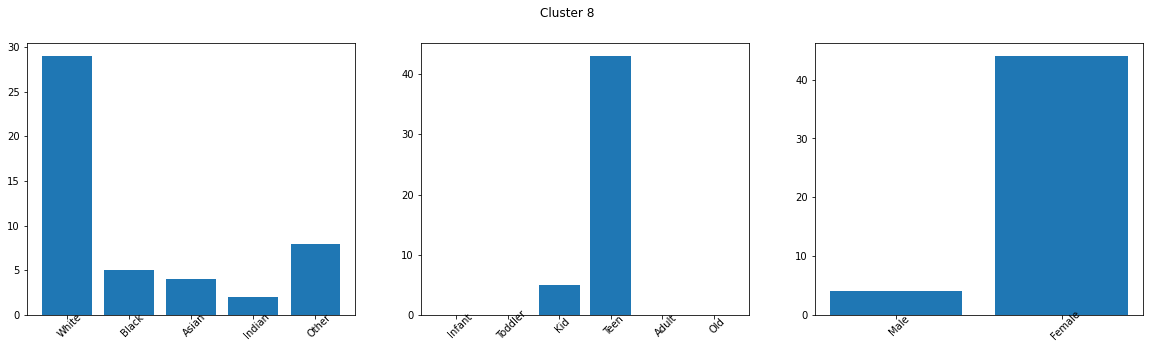

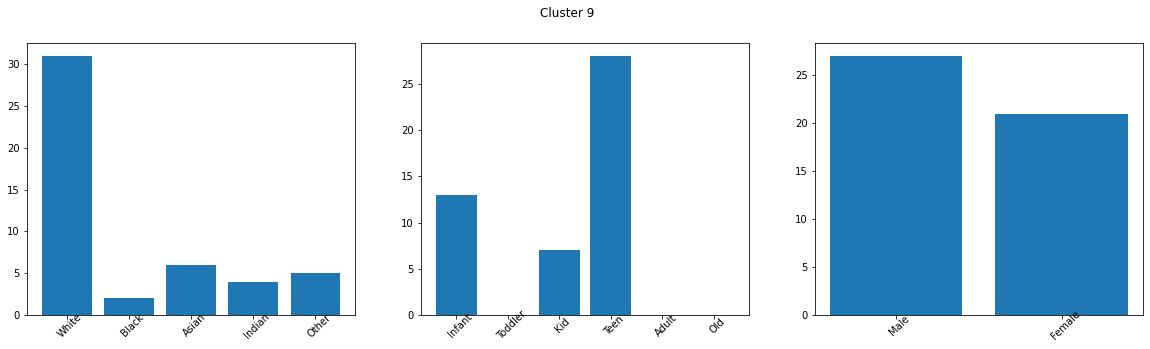

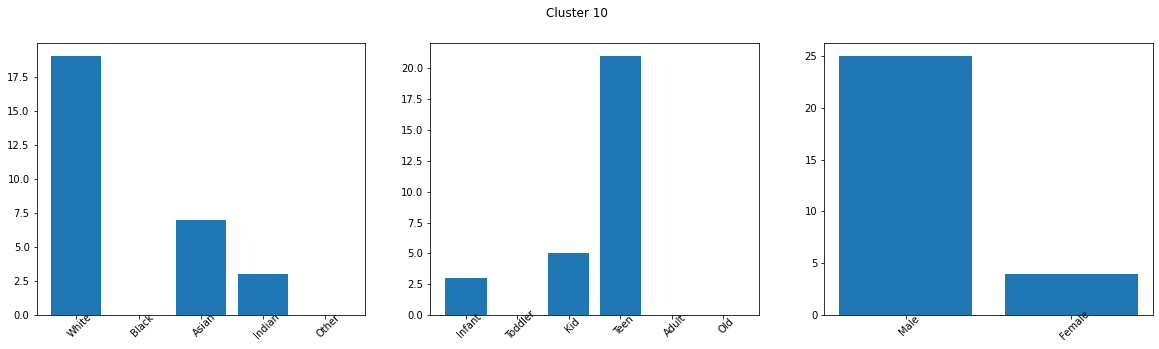

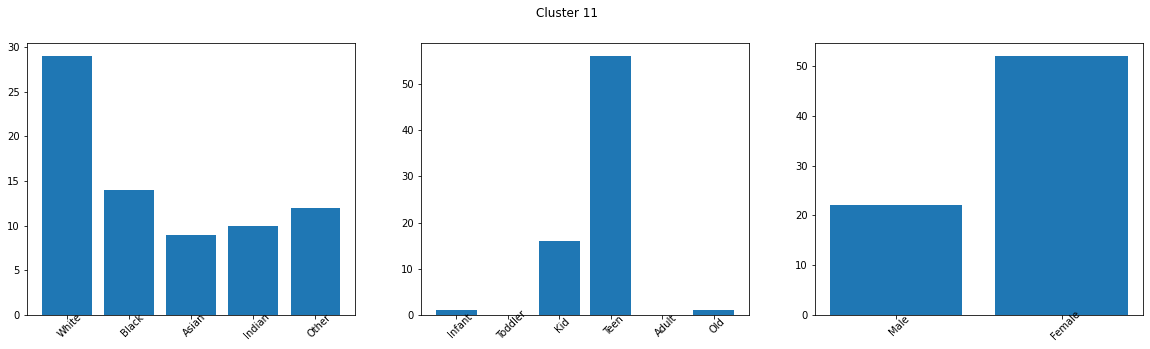

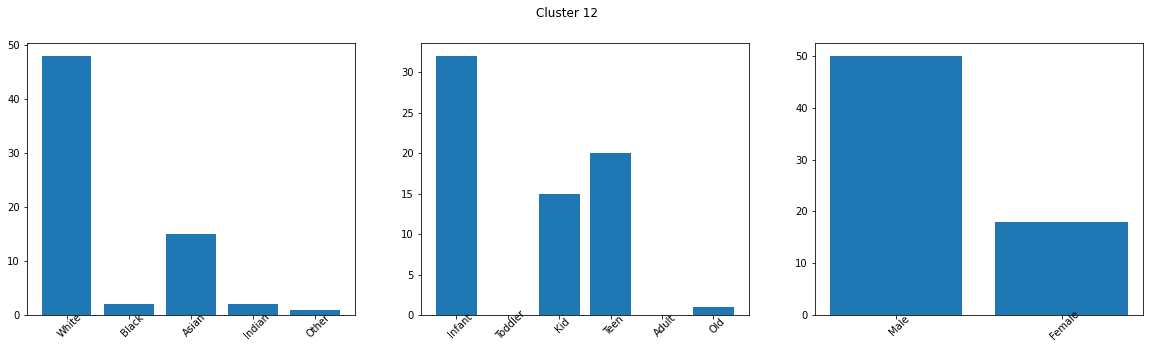

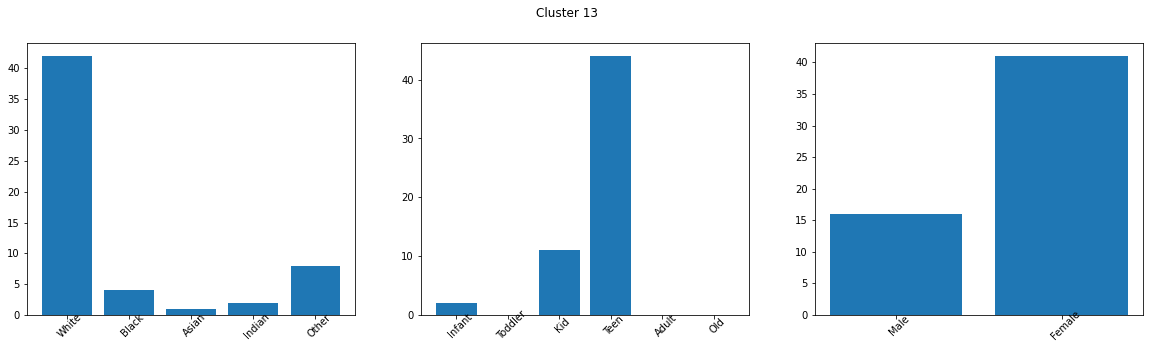

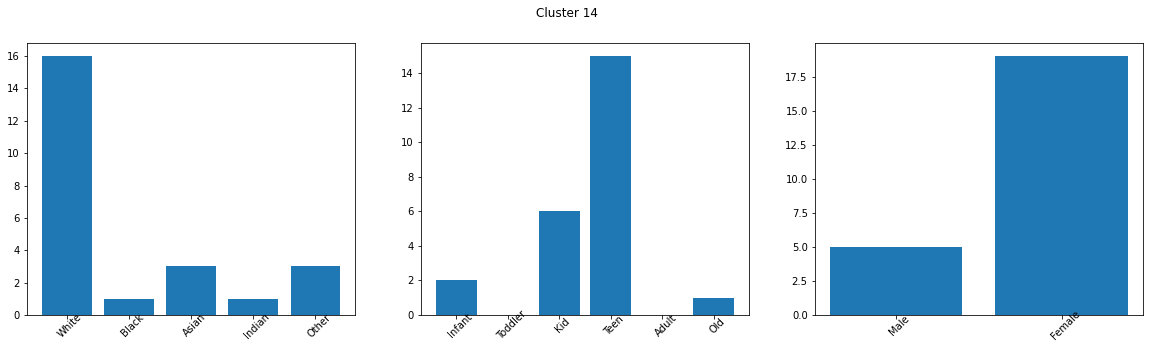

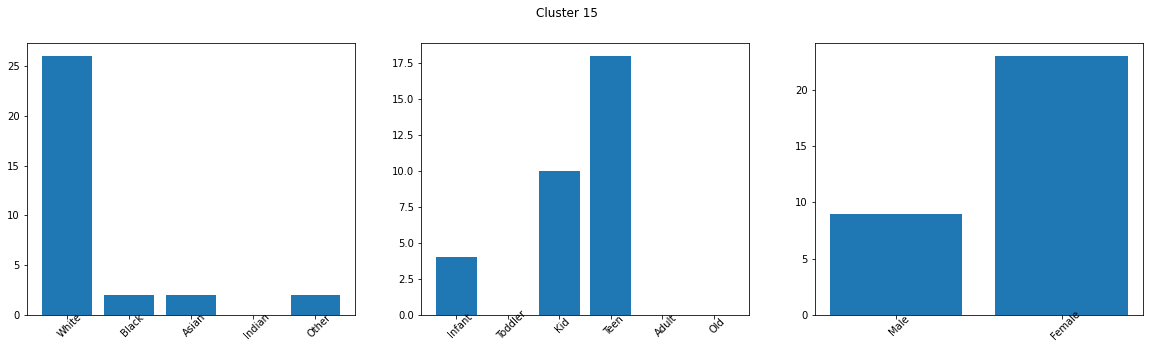

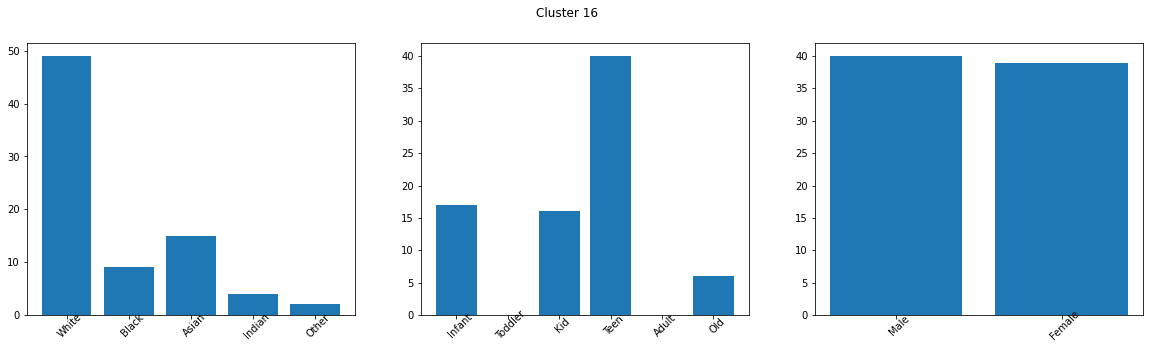

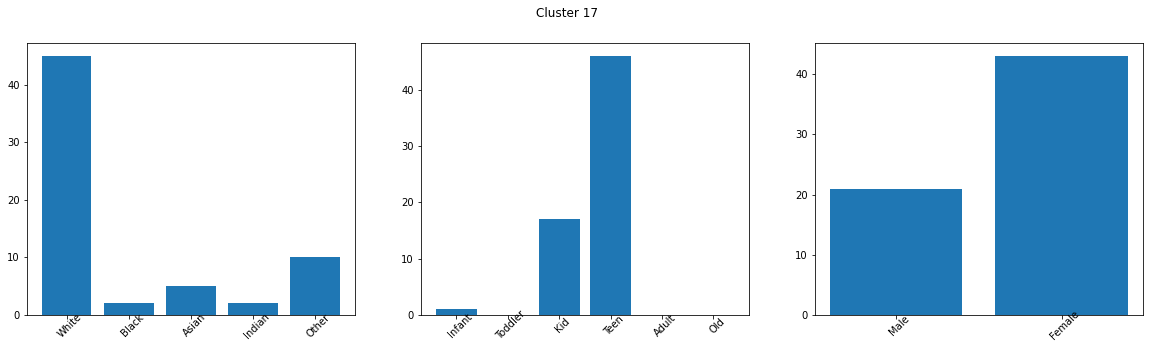

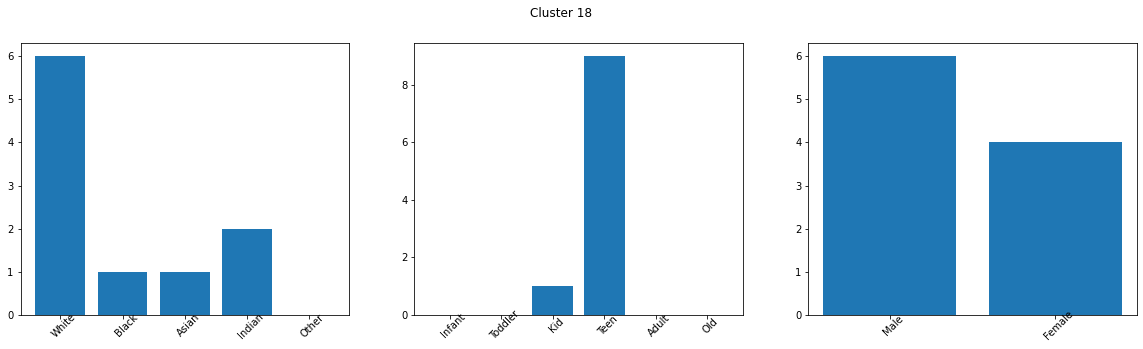

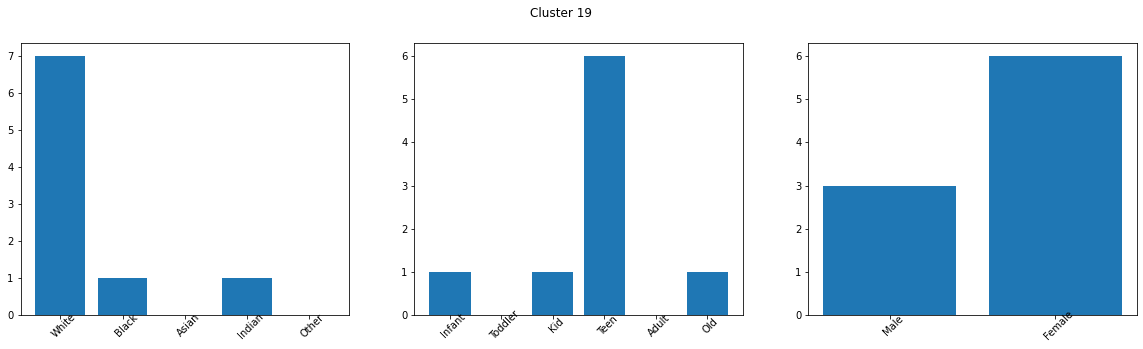

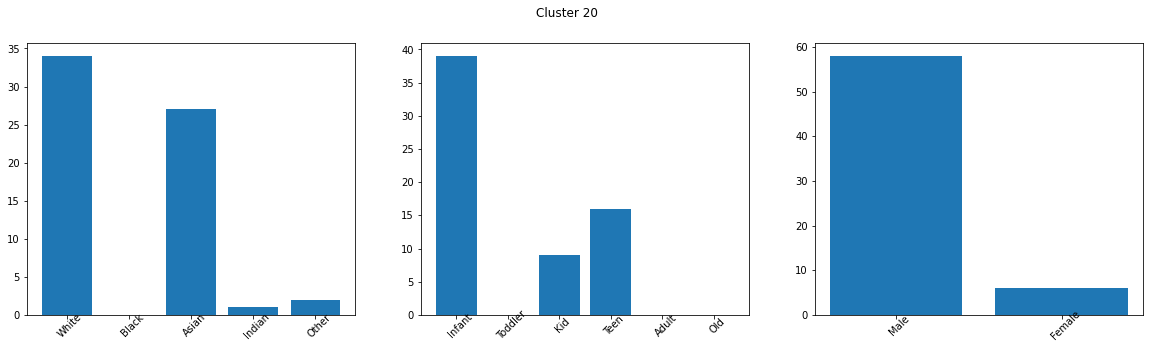

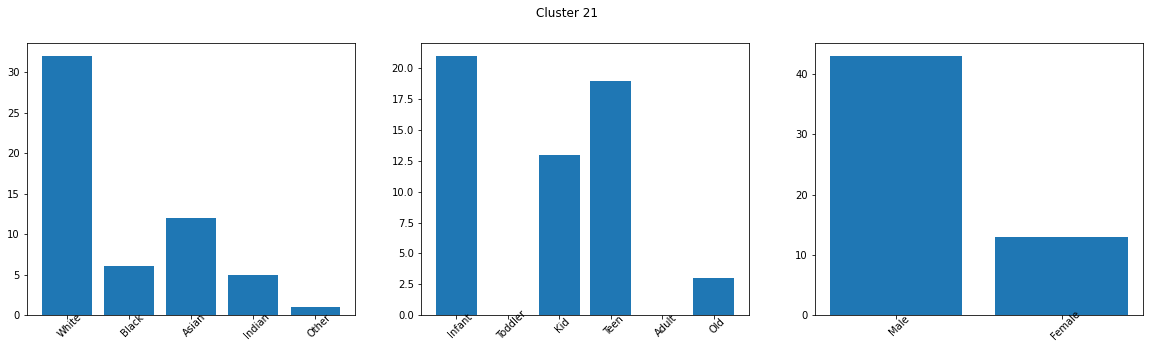

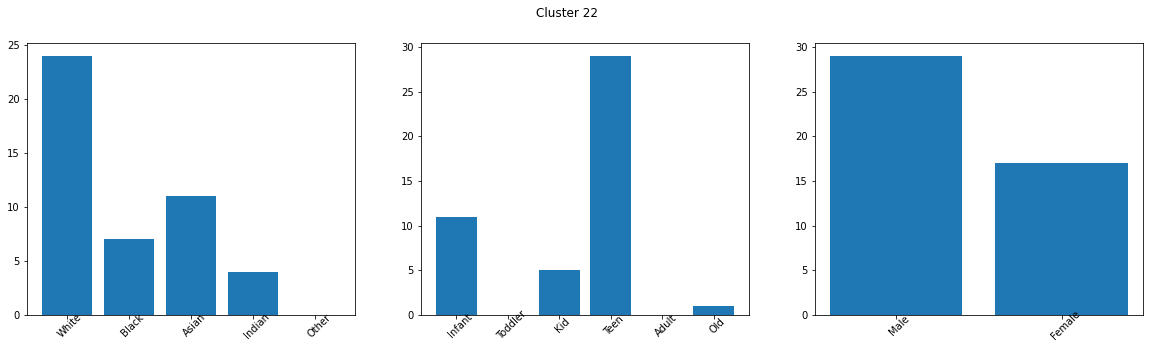

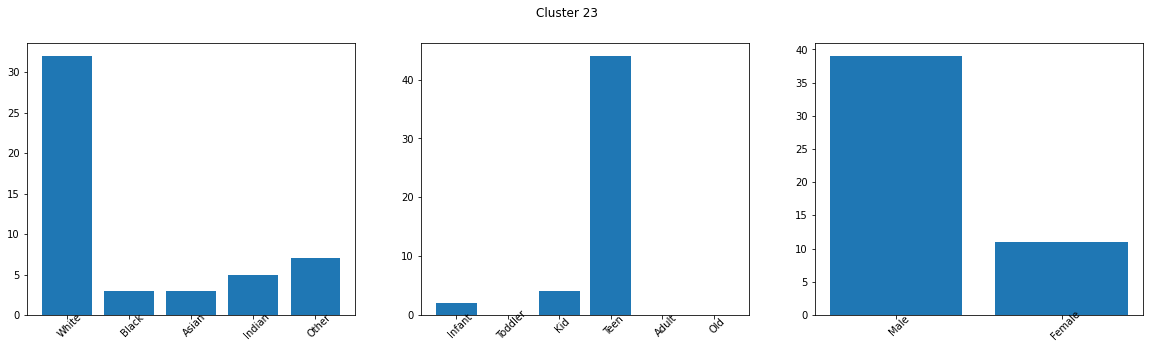

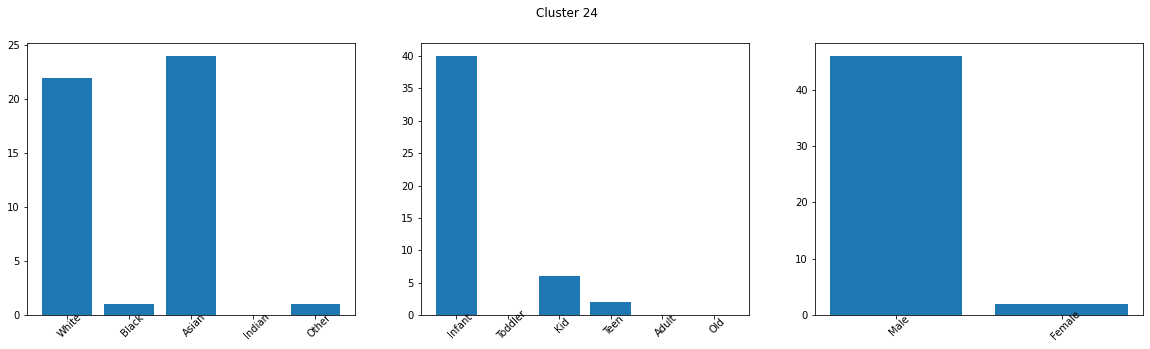

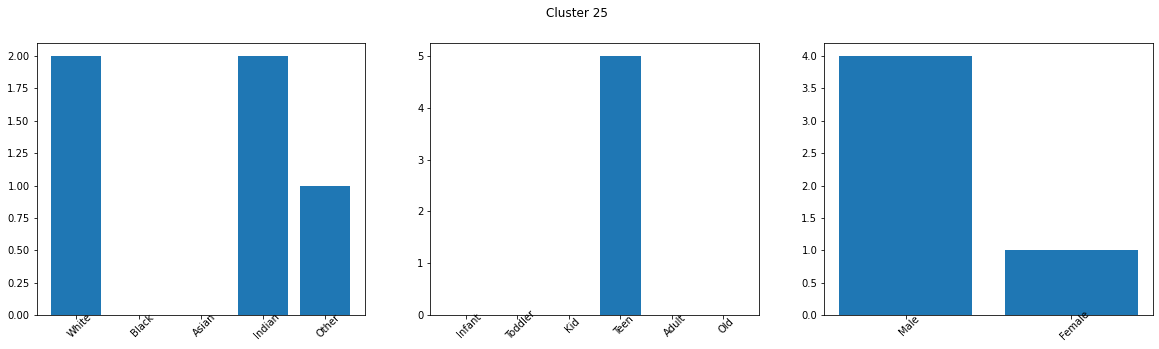

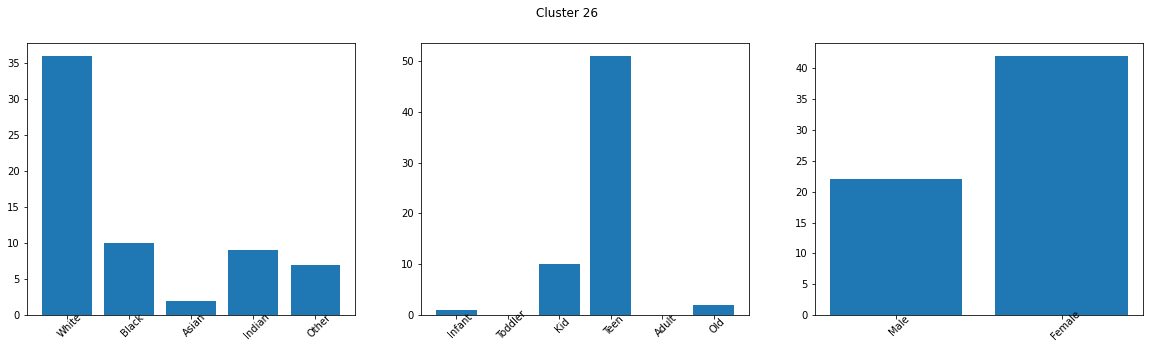

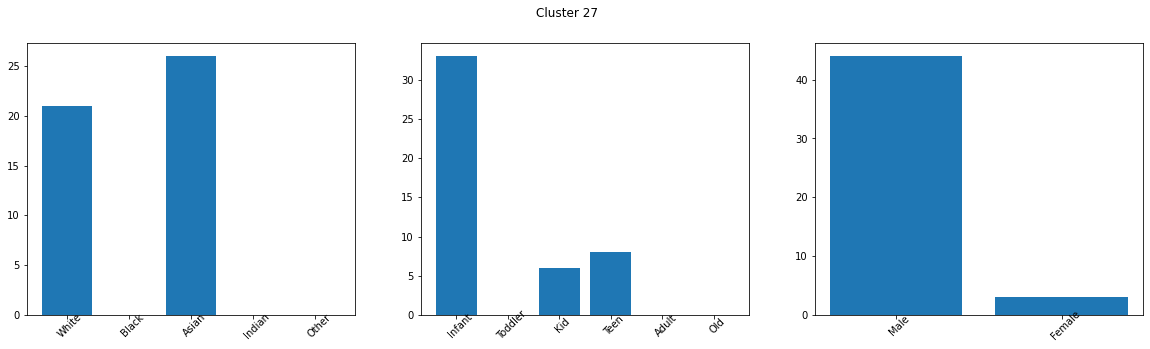

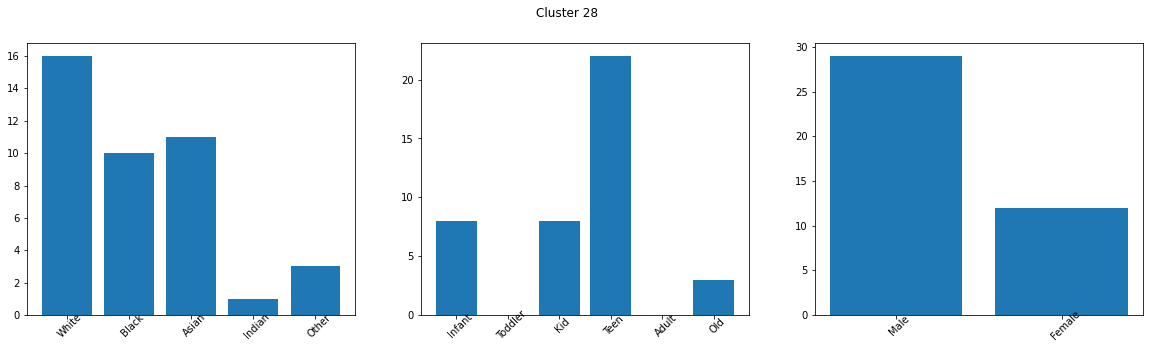

In [222]:
for i in range (1,30):
    fig = plt.figure(figsize=(20,5))
    fig.suptitle('Cluster ' + str(i-1))

    plt.subplot(1, 3, 1)
    plotter(label_count_race[i-1], class_names_race) 

    plt.subplot(1, 3, 2)
    plotter(label_count_age[i-1], class_names_age) 

    plt.subplot(1, 3, 3)
    plotter(label_count_gender[i-1], class_names_gender) 


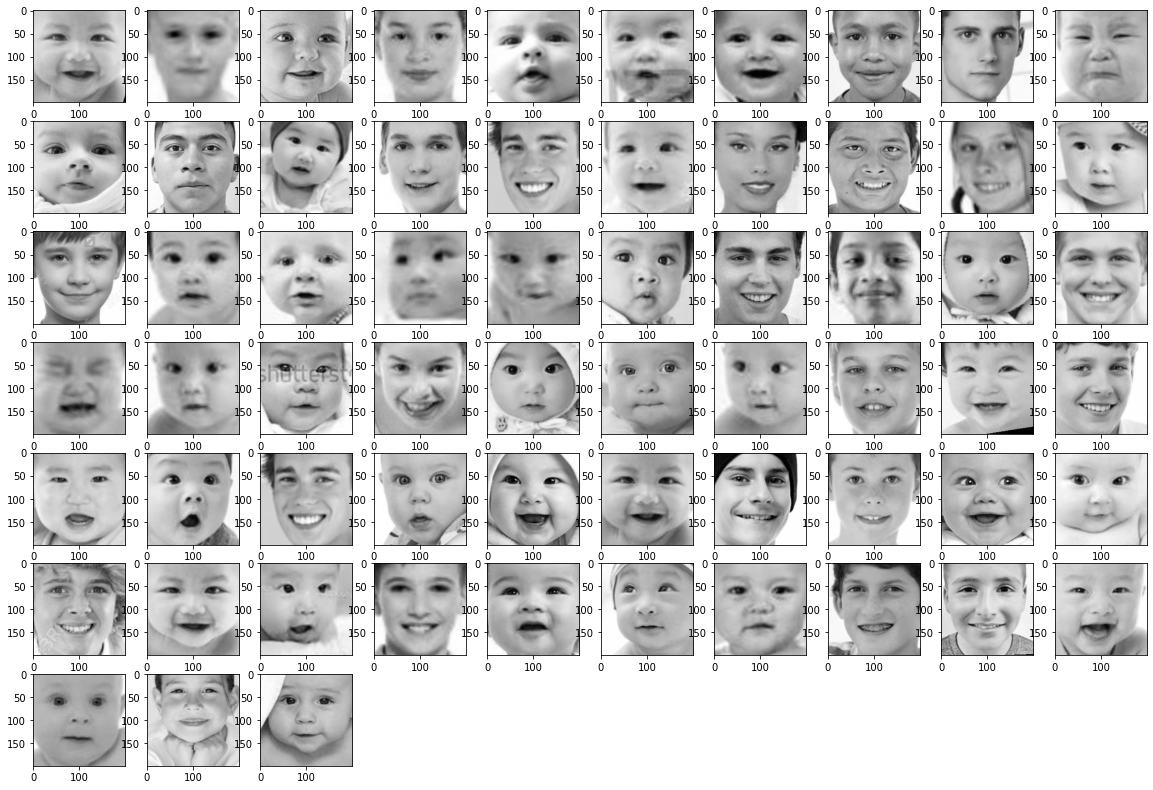

In [224]:
#Visualisation for clusters = clust
plt.figure(figsize=(20,20));
clust = 20 # enter label number to visualise

cluster_len = len(cluster_index[clust])
num = cluster_len if cluster_len<100 else 100 # num of data to visualize from the cluster
for i in range(1,num): 
    plt.subplot(10, 10, i); #(Number of rows, Number of column per row, item number)
    plt.imshow(X_train[cluster_index[clust][i]].reshape(h,w), cmap = 'gray');
    
plt.show()